# PermRowCol experimental results

In [11]:
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from pyzx import cnot_mapper, architecture # Note that this is the local pyzx package from this repository/fork, not the one installed through pip or other means.

First, we specify some code to read the dataset of CNOT circuits that was used in [ArXiv 1904.00633](https://arxiv.org/pdf/1904.00633.pdf). Since the original paper only used 20 circuits per test case (number of qubits, number of original CNOTs), we generated 80 more circuits that are now available on this GitHub repository in the folder circuits/steiner/

In [2]:
def read_circuit(source):
    if not os.path.exists(source):
        print("File {} does not exist".format(source))
        return
    return cnot_mapper.CNOT_tracker.from_qasm_file(source)

def read_circuits(n_qubits):
    source_folder = "../circuits/steiner/"
    circuits = []
    sources = []
    subfolder = os.path.join(source_folder, str(n_qubits)+"qubits/")

    for folder in os.listdir(subfolder):
        folder = os.path.join(subfolder, folder)
        if os.path.isdir(folder):
            for file in os.listdir(folder):
                if file.endswith(".qasm"):
                    src = os.path.join(folder, file)
                    circuit = read_circuit(src)
                    circuits.append(circuit)
                    sources.append(src)
    return circuits, sources

In [3]:
archs = [
    architecture.create_architecture(architecture.SQUARE, n_qubits=9),
    architecture.create_architecture(architecture.SQUARE, n_qubits=16),
    architecture.create_architecture(architecture.RIGETTI_16Q_ASPEN),
    architecture.create_architecture(architecture.IBM_QX5),
    architecture.create_architecture(architecture.IBM_Q20_TOKYO)
]

Then we run our experiment with the algorithms as they are.

In [4]:
def run_steiner_gauss(circuit, arch):
    c = cnot_mapper.CNOT_tracker(circuit.n_qubits)
    cnot_mapper.gauss(cnot_mapper.STEINER_MODE, circuit.matrix.copy(), architecture=arch, y=c, full_reduce=True)
    return c.count_cnots()

def run_rowcol(circuit, arch):
    c = cnot_mapper.CNOT_tracker(circuit.n_qubits)
    cnot_mapper.gauss(cnot_mapper.ROWCOL_MODE, circuit.matrix.copy(), architecture=arch, y=c, full_reduce=True)
    return c.count_cnots()

def run_perm_rowcol(circuit, arch, chooseRow=None, chooseColumn=None):
    c = cnot_mapper.CNOT_tracker(circuit.n_qubits)
    cnot_mapper.permrowcol(circuit.matrix.copy(), architecture=arch, y=c, chooseRow=chooseRow, chooseColumn=chooseColumn)
    return c.count_cnots()

def run_experiment(arch):
    n_qubits = arch.n_qubits
    og_circuits, srcs = read_circuits(n_qubits)
    results = pd.DataFrame()

    method = {
        "SteinerGauss": run_steiner_gauss,
        "RowCol": run_rowcol,
        "PermRowCol": run_perm_rowcol
    }

    results["Original"] = np.array([int(src.split("/")[-2]) for src in srcs])
    results["#Qubits"] = np.array([n_qubits]*len(og_circuits))
    results["Architecture"] = np.array([arch.name]*len(og_circuits))
    
    for m, func in method.items():
        results[(m, "count")] = np.array([func(c, arch) for c in og_circuits])
        results[(m, "overhead (%)")] = (results[(m, "count")]/results["Original"] - 1)*100

    results = results.groupby(["Original", "Architecture", "#Qubits"]).mean()

    results.columns = pd.MultiIndex.from_tuples(results.columns.tolist())    
    return results

In [5]:
results = pd.concat([run_experiment(arch) for arch in archs])
results.to_csv("PermRowCol results.csv")

The PermRowCol algorithm relies on heuristical functions for determining which row and column to pick. Below are some example functions to to play around with. By default, the behavior uses `ChooseRowMin` and `ChooseRowMax` (hardcoded in `permrowcol`).

In [5]:
def chooseRowMin(m, o):
    return o[np.argmin([sum(m.data[i]) for i in o])]

def chooseColumnMin(m, r, o):
    return o[np.argmin([sum(m.data[i]) if m.data[r][i] == 1 else len(m.data) for i in o])] 

def chooseRowMax(m, o):
    return o[np.argmax([sum(m.data[i]) for i in o])]

def chooseColumnMax(m, r, o):
    return o[np.argmax([sum(m.data[i]) if m.data[r][i] == 1 else 0 for i in o])] 

## Unconstrained experiments
Because there are more applications for Gaussian elimination where the number of steps are counted and the resulting matrix can also be a permutation matrix, we also compare our algorithm in case that there are no connectivity constraints. 

For example, this can be useful in ZX diagram extraction.

In [7]:
fully_connected_archs = [architecture.create_architecture(architecture.FULLY_CONNNECTED, n_qubits=n) for n in [5, 9, 16, 20]]

In [8]:
results = pd.concat([run_experiment(arch) for arch in fully_connected_archs])
results.to_csv("PermRowCol results UNCONSTRAINED.csv")

# Visualization


In [6]:
def plot_results(filename, architectures):
    df = pd.read_csv(filename, header=[0,1,2])
    for i, arch in enumerate(architectures):
        tmp_df = df[df[df.columns[1]] == arch.name]
        original = tmp_df[df.columns[0]]
        steinergauss = tmp_df[df.columns[3]]
        rowcol = tmp_df[df.columns[5]]
        permrowcol = tmp_df[df.columns[7]]

        plt.figure(i)
        plt.plot(original, original, label="x=y")
        plt.plot(original, steinergauss, label="Steiner-Gauss")
        plt.plot(original, rowcol, label="RowCol")
        plt.plot(original, permrowcol, label="PermRowCol")
        plt.xlabel("Original CNOT count")
        plt.ylabel("Routed CNOT count")
        plt.title(arch.name)
        plt.legend()
        plt.savefig("figs/"+arch.name, dpi=150)
        plt.show()


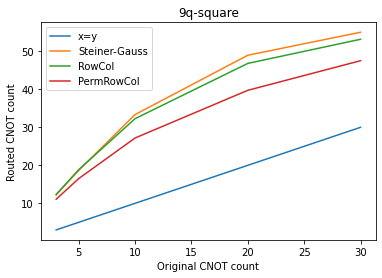

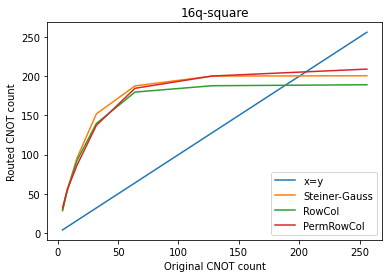

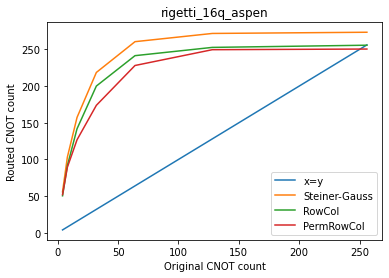

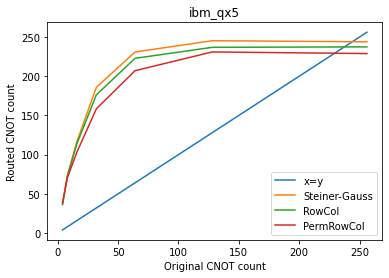

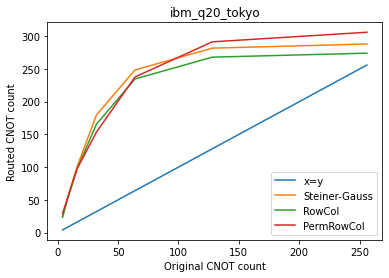

In [10]:
filename = "PermRowCol results.csv"
plot_results(filename, archs)

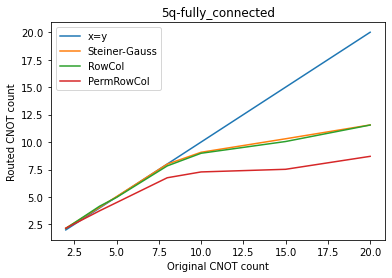

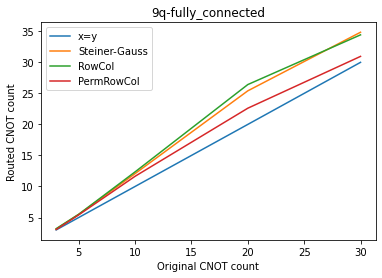

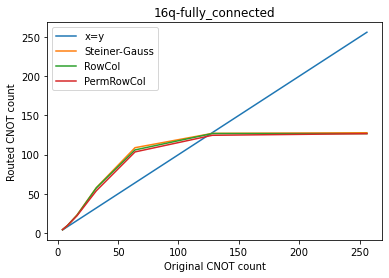

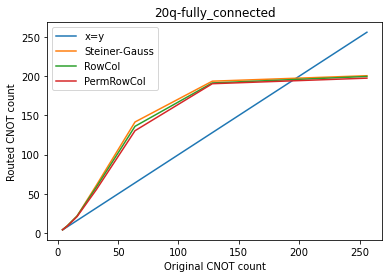

In [11]:
filename = "PermRowCol results UNCONSTRAINED.csv"
plot_results(filename, fully_connected_archs)

# NEW RESULTS
Our paper was still work in progress, below you will see new preliminary results that are correct.

## Reverse Traversal strategy
PermRowCol can find a new output qubit placement, but it leaves the original qubits where they are. 
We can optimize the original qubit allocation using the reverse traversal strategy from SABRE. This means that we synthesize the circuit for to a new qubit allocation and then use that new output qubit allocation as the initial qubit allocation for the reverse circuit (inverse parity matrix). Then we repeat this back-and-forth resynthesis a couple of times to get a better allocation.

In [9]:

# Reverse traversal parameters
RT_parameters = {
    "max_iter" : 15
}

def run_reverse_traversal(circuit, arch): 
    circuit, initial_mapping, output_mapping = cnot_mapper.reverse_traversal(circuit.matrix.copy(), architecture=arch, **RT_parameters)
    return circuit.count_cnots()

def run_RT_experiment(arch):
    n_qubits = arch.n_qubits
    og_circuits, srcs = read_circuits(n_qubits)
    results = pd.DataFrame()

    method = {
        "ReverseTraversal" : run_reverse_traversal,
        "PermRowCol": run_perm_rowcol,
    }

    results["Original"] = np.array([int(src.split("/")[-2]) for src in srcs])
    results["#Qubits"] = np.array([n_qubits]*len(og_circuits))
    results["Architecture"] = np.array([arch.name]*len(og_circuits))
    
    for m, func in method.items():
        results[(m, "count")] = np.array([func(c, arch) for c in og_circuits])
        results[(m, "overhead (%)")] = (results[(m, "count")]/results["Original"] - 1)*100

    results = results.groupby(["Original", "Architecture", "#Qubits"]).mean()

    results.columns = pd.MultiIndex.from_tuples(results.columns.tolist())   
    return results

In [10]:
results = pd.concat([run_RT_experiment(arch) for arch in archs])
results.to_csv("PermRowCol results RT.csv")
results

ReverseTraversal              PermRowCol  \
                                              count overhead (%)      count   
Original Architecture      #Qubits                                            
3        9q-square         9                   4.85    61.666667      11.08   
5        9q-square         9                   7.24    44.800000      16.51   
10       9q-square         9                  14.99    49.900000      27.19   
20       9q-square         9                  25.54    27.700000      39.74   
30       9q-square         9                  32.70     9.000000      47.53   
4        16q-square        16                  7.10    77.500000      31.98   
8        16q-square        16                 20.18   152.250000      55.66   
16       16q-square        16                 46.87   192.937500      86.55   
32       16q-square        16                 95.07   197.093750     137.30   
64       16q-square        16                145.21   126.890625     184.55   
128      16q-square        16                164.17    28.257812     200.19   
256      16q-square        16                166.68   -34.890625     209.02   
4        rigetti_16q_aspen 16                 13.07   226.750000      52.17   
8        rigetti_16q_aspen 16                 36.31   353.875000      89.40   
16       rigetti_16q_aspen 16                 75.42   371.375000     126.80   
32       rigetti_16q_aspen 16                128.17   300.531250     173.74   
64       rigetti_16q_aspen 16                180.55   182.109375     227.98   
128      rigetti_16q_aspen 16                208.88    63.187500     249.50   
256      rigetti_16q_aspen 16                209.33   -18.230469     250.39   
4        ibm_qx5           16                  9.54   138.500000      38.72   
8        ibm_qx5           16                 24.68   208.500000      70.46   
16       ibm_qx5           16                 58.88   268.000000     103.58   
32       ibm_qx5           16                112.64   252.000000     158.39   
64       ibm_qx5           16                164.64   157.250000     206.96   
128      ibm_qx5           16                188.71    47.429688     230.90   
256      ibm_qx5           16                191.72   -25.109375     228.81   
4        ibm_q20_tokyo     20                  6.39    59.750000      29.39   
8        ibm_q20_tokyo     20                 16.36   104.500000      51.59   
16       ibm_q20_tokyo     20                 46.08   188.000000      97.39   
32       ibm_q20_tokyo     20                107.56   236.125000     153.15   
64       ibm_q20_tokyo     20                191.37   199.015625     237.72   
128      ibm_q20_tokyo     20                248.55    94.179688     291.40   
256      ibm_q20_tokyo     20                255.87    -0.050781     306.06   

                                                 
                                   overhead (%)  
Original Architecture      #Qubits               
3        9q-square         9         269.333333  
5        9q-square         9         230.200000  
10       9q-square         9         171.900000  
20       9q-square         9          98.700000  
30       9q-square         9          58.433333  
4        16q-square        16        699.500000  
8        16q-square        16        595.750000  
16       16q-square        16        440.937500  
32       16q-square        16        329.062500  
64       16q-square        16        188.359375  
128      16q-square        16         56.398438  
256      16q-square        16        -18.351562  
4        rigetti_16q_aspen 16       1204.250000  
8        rigetti_16q_aspen 16       1017.500000  
16       rigetti_16q_aspen 16        692.500000  
32       rigetti_16q_aspen 16        442.937500  
64       rigetti_16q_aspen 16        256.218750  
128      rigetti_16q_aspen 16         94.921875  
256      rigetti_16q_aspen 16         -2.191406  
4        ibm_qx5           16        868.000000  
8        ibm_qx5           16        780

In [12]:
def plot_RT_results(filename, architectures):
    df = pd.read_csv(filename, header=[0,1,2])
    for i, arch in enumerate(architectures):
        tmp_df = df[df[df.columns[1]] == arch.name]
        original = tmp_df[df.columns[0]]
        reversetraversal = tmp_df[df.columns[3]]
        permrowcol = tmp_df[df.columns[5]]

        plt.figure(i)
        plt.plot(original, original, label="x=y")
        plt.plot(original, reversetraversal, label="w/ Reverse Traversal")
        plt.plot(original, permrowcol, label="w/o Reverse Traversal")
        plt.xlabel("Original CNOT count")
        plt.ylabel("Routed CNOT count")
        plt.title(arch.name)
        plt.legend()
        plt.savefig("figs/RT_"+arch.name, dpi=150)
        plt.show()

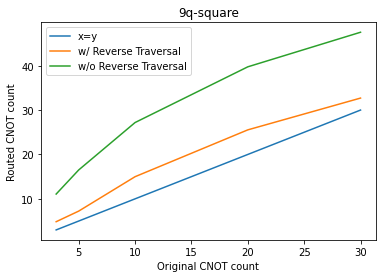

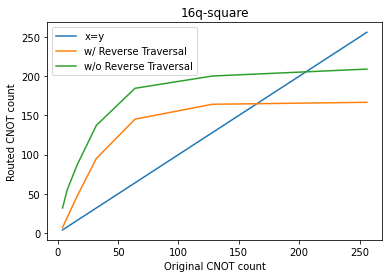

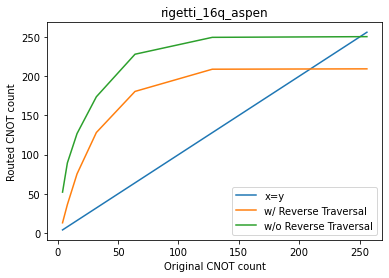

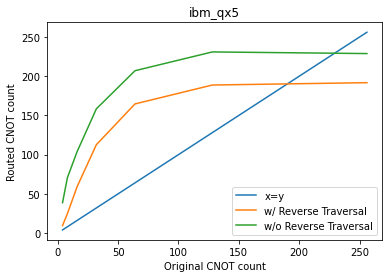

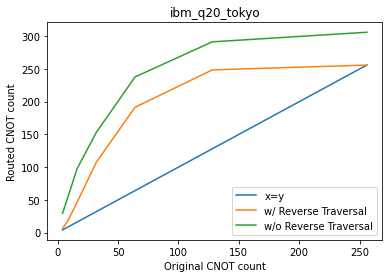

In [13]:
plot_RT_results("PermRowCol results RT.csv", archs)

# Work in progress

The following code is still under development and the results are currently unreliable. 

## Genetic algorithm vs reverse traversal
Note that these numbers do not correspond with the original paper for the SteinerGauss algorithm. The reason is that in the paper, we used a genetic algorithm to improve the mapping of the circuit. 
However, we can see that for the algorithms on their own the new PermRowCol algorithm is consistently finding less CNOTs.

Next, we will compare the results with the genetic algorithm for optimizing the initial qubit mapping for the SteinerGauss and RowCol algorithms, and compare that against the PermRowCol combined with a Reverse Traversal strategy for optimizing the mapping.

In [7]:
# Genetic algorithm parameters per #qubits
GA_parameters = {
    9: {
        "population": 30,
        "iter" : 5,
        "crossover": 0.8,
        "mutation":0.2
    },
    16: {
        "population": 50,
        "iter" : 100,
        "crossover": 0.8,
        "mutation":0.2
    },
    20: {
        "population": 100,
        "iter" : 100,
        "crossover": 0.8,
        "mutation":0.2
    },
}


def run_genetic_steiner_gauss(circuit, arch):
    params = GA_parameters[circuit.n_qubits]
    c = cnot_mapper.CNOT_tracker(circuit.n_qubits)
    cnot_mapper.gauss(cnot_mapper.GENETIC_GAUSS_MODE, circuit.matrix.copy(), architecture=arch, y=c, full_reduce=True,
                        population_size=params["population"], n_iterations=params["iter"], crossover_prob=params["crossover"], mutate_prob=params["mutation"])
    return c.count_cnots()

def run_genetic_rowcol(circuit, arch): # TODO make this functional
    params = GA_parameters[circuit.n_qubits]
    c = cnot_mapper.CNOT_tracker(circuit.n_qubits)
    cnot_mapper.gauss(cnot_mapper.GENETIC_ROWCOL_MODE, circuit.matrix.copy(), architecture=arch, y=c, full_reduce=True,
                        population_size=params["population"], n_iterations=params["iter"], crossover_prob=params["crossover"], mutate_prob=params["mutation"])
    return c.count_cnots()

def run_genetic_permrowcol(circuit, arch): # TODO make this functional
    params = GA_parameters[circuit.n_qubits]
    c = cnot_mapper.CNOT_tracker(circuit.n_qubits)
    cnot_mapper.gauss(cnot_mapper.GENETIC_PERMROWCOL_MODE, circuit.matrix.copy(), architecture=arch, y=c, full_reduce=True,
                        population_size=params["population"], n_iterations=params["iter"], crossover_prob=params["crossover"], mutate_prob=params["mutation"])
    return c.count_cnots()

def run_GA_experiment(arch):
    n_qubits = arch.n_qubits
    og_circuits, srcs = read_circuits(n_qubits)
    results = pd.DataFrame()

    method = {
        "ReverseTraversal" : run_reverse_traversal,
        "PermRowCol": run_genetic_permrowcol,
        "SteinerGauss": run_genetic_steiner_gauss,
        "RowCol": run_genetic_rowcol
    }

    results["Original"] = np.array([int(src.split("/")[-2]) for src in srcs])
    results["#Qubits"] = np.array([n_qubits]*len(og_circuits))
    results["Architecture"] = np.array([arch.name]*len(og_circuits))
    
    for m, func in method.items():
        results[(m, "count")] = np.array([func(c, arch) for c in og_circuits])
        results[(m, "overhead (%)")] = (results[(m, "count")]/results["Original"] - 1)*100
        print(results.groupby(["Original", "Architecture", "#Qubits"]).mean())

    results = results.groupby(["Original", "Architecture", "#Qubits"]).mean()

    results.columns = pd.MultiIndex.from_tuples(results.columns.tolist())   
    print(results) 
    return results

In [8]:
results = pd.concat([run_GA_experiment(arch) for arch in archs])
results.to_csv("PermRowCol results GA.csv")
results

                               (ReverseTraversal, count)  \
Original Architecture #Qubits                              
3        9q-square    9                             4.85   
5        9q-square    9                             7.19   
10       9q-square    9                            14.40   
20       9q-square    9                            23.38   
30       9q-square    9                            29.58   

                               (ReverseTraversal, overhead (%))  
Original Architecture #Qubits                                    
3        9q-square    9                               61.666667  
5        9q-square    9                               43.800000  
10       9q-square    9                               44.000000  
20       9q-square    9                               16.900000  
30       9q-square    9                               -1.400000  


KeyboardInterrupt: 